In [ ]:
import matplotlib.pyplot as plt

from qutip import Qobj, jmat, qeye
from functools import partial
from scipy.optimize import minimize
from scipy.integrate import simpson
import torch
import numpy as np
from scipy.linalg import expm
from math import floor
det = torch.linalg.det
pi = np.pi
exp = np.exp
s = np.sqrt
i = 1j


## General Definitions

In [429]:
#Jx, Jy, Jz defined for R_x(t) = exp(i Jx t / 2) convention
def jx(d):
    """Generate the generalized X gate for SU(d) using jmat."""
    Jx = np.array(2 * jmat((d - 1) / 2, 'x').full())
    return Jx
def jy(d):
    """Generate the generalized Y gate for SU(d) using jmat."""
    Jy = np.array(2 * jmat((d - 1) / 2, 'y').full())
    return Jy
def jz(d):
    """Generate the generalized X gate for SU(d) using jmat."""
    Jz = np.array(2 * jmat((d - 1) / 2, 'z').full())
    return Jz

### SU(2) Definitions for Unitary Evolution and Filter Functions

In [433]:
sx = jx(2)
sy = jy(2)
sz = jz(2)

In [ ]:
def axis(theta, phi):
    """
    Convert spherical coordinates to Cartesian coordinates for rotation axis.
    
    Parameters:
    theta: polar angle in radians
    phi: azimuthal angle in radians
    
    Returns:
    list: Cartesian coordinates [x, y, z]
    """

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return [x, y, z]

def R(d, axis, theta):
    """Generalized rotation operator for SU(d)
    
    Parameters:
    d: dimension of the SU(d) group
    axis: rotation axis as a 3D vector
    theta: rotation angle in radians
    """
    mat = jx(d) * axis[0] + jy(d) * axis[1] + jz(d) * axis[2]
    return (-1j * mat * theta / 2).expm()

def unitary_evo_piecewise(H_list):
    """
    Creates the time evolution operator U(t) by propagating a piecewise constant Hamiltonian.
    Naturally time-ordered.

    Parameters:
    H_list: list or array of 2x2 Hamiltonians H_k and time steps dt_k: [(H_1, dt_1), (H_2, dt_2), ...]
    """
    U = np.eye(2, dtype=complex)
    U_history = [U.copy()]
    times = [0]

    for (H, dt) in H_list:
        U_step = expm(-1j * H * dt)
        U = U_step @ U
        U_history.append(U)
        times.append(times[-1] + dt)

    return np.array(U_history)

def generate_time_series(S, N, dt):
    """
    Generate a time series with a given spectral density S(w).
    
    Parameters:
    S (function): A function that takes angular frequency (omega) and returns the spectral density.
    N (int): Number of time points.
    dt (float): Time step.
    
    Returns:
    np.ndarray: The generated time series.
    np.ndarray: The frequencies for the spectral density plot.
    np.ndarray: The calculated spectral density of the generated time series.
    """
    # Step 1: Generate white noise time series
    white_noise = np.random.normal(0, 1/np.sqrt(dt), N)
    
    # Step 2: Transform to frequency domain
    white_noise_fft = np.fft.fft(white_noise)
    freqs = np.fft.fftfreq(N, dt)
    
    # Step 3: Apply the desired spectral density
    scaling_factor = np.sqrt(S(2 * np.pi * np.abs(freqs)))
    scaling_factor[0] = 0  # Avoid division by zero for the zero frequency component
    
    scaled_fft = white_noise_fft * scaling_factor
    
    # Step 4: Transform back to time domain
    time_series = np.fft.ifft(scaled_fft)
    
    # Calculate the spectral density of the generated time series
    generated_fft = np.fft.fft(time_series)
    generated_psd = (np.abs(generated_fft)**2) / N
    
    # Returning the real part of the time series and the frequencies and PSD for plotting
    return np.real(time_series), freqs, generated_psd

def noise_interpolation(values, df, f):
    """
    Linearly interpolates between values in an array that are equally spaced in time,
    and wraps around at the end of the array.

    Parameters:
    values (array-like): Array of values equally spaced in time.
    df (float): Frequency spacing between the values.
    f (float): Input frequency at which to interpolate.

    Returns:
    float: Interpolated value at frequency f.
    """
    num_values = len(values)
    total_freqs= num_values * df

    # Normalize time t to be within the range [0, total_time)
    f = f % total_freqs

    # Find the indices of the two values to interpolate between
    index1 = int(f // df)
    index2 = (index1 + 1) % num_values

    # Find the fractional part of t within the interval [index1*dt, (index1+1)*dt]
    f1 = index1 * df
    f2 = index2 * df
    fraction = (f - f1) / df


    # Perform linear interpolation
    interpolated_value = (1 - fraction) * values[index1] + fraction * values[index2]
    return interpolated_value

def create_H_list(params, dt, noise_type = -1, S=0):
    """
    Create a list of Hamiltonians for the given pulse sequence parameters and time step.
    
    params: list or array of parameters each row [omega_k, axis_k, delta_k, tau_k] 
        where omega_k is rotation amplitude, axis_k is rotation axis angle, delta_k is detuning, tau_k is duration   
    dt: time step to create list of Hamiltonians at
    noise_type: type of noise to add (-1 = none, 0 = White, 1 = 1/f, 2 = 1/f^2, etc)

    Returns: list of Hamiltonians and time steps [(H_1, dt_1), (H_2, dt_2), ...]
    """
    total_time = np.sum(params[:, 5])
    total_num_bins  = int(total_time / dt) + len(params)
    total_times = [0]
    if noise_type >= 0:
        betas = generate_time_series(lambda f:S/(f ** noise_type + 1e-14), total_num_bins, dt)[0]
    else:
        betas = np.zeros(total_num_bins)

    H_list = []
    curr_time = 0
    for row in params:
        omega = row[0]
        axis = [row[1], row[2], row[3]]
        delta = row[4]
        tau = row[5]

        num_bins = int(tau / dt)
        final_dt = tau - num_bins * dt
        
        if final_dt > 1e-12:
            times = np.arange(num_bins+1) * dt + curr_time
            times = np.append(times, times[-1] + final_dt)
        else:
            times = np.arange(num_bins+1) * dt + curr_time
        tot_bins = len(times)
        if noise_type >= 0:
            interp_noise_points = [noise_interpolation(betas, dt, t) for t in times]
        
        H = omega * (axis[0] * sx + axis[1] * sy + axis[2] * sz) / 2 + delta * sz / 2 # Hamiltonian for this segment
        for k in range(num_bins):
            if noise_type >= 0:
                H_list.append([H + interp_noise_points[k] * sz / 2, dt])
            else:
                H_list.append([H, dt])
        if final_dt > 1e-12:
            if noise_type >= 0:
                H_list.append([H + interp_noise_points[tot_bins-1] * sz / 2, final_dt])
            else:
                H_list.append([H, final_dt])
        curr_time += tau
        total_times += list(times[:-1])

    return H_list, total_times

def U_qsp_from_polys(t, polys):
    """
    Constructs the unitary operator for instant equiangular QSP given the polynomial coefficients.
    
    Parameters:
    t: array of time points
    polys: list of functions [P, Q, start_time, end_time] where P and Q are lambda functions
    Returns:
    np.ndarray: The unitary operator U corresponding to the QSP polynomials.
    """ 
    U_history = []
    for time in t:
        # Find the corresponding polynomial segment
        for poly in polys:
            P, Q, start_time, end_time = poly
            if start_time <= time < end_time:
                break
        # Evaluate the polynomials at the current time
        p_val = P(time)
        q_val = Q(time)
        # Construct the unitary for this time segment
        U_t = np.array([[p_val, 1j * q_val],
                        [1j * np.conj(q_val), np.conj(p_val)]])
        # Update the overall unitary
        U_history.append(U_t)
    return np.array(U_history)

def create_polys_equiXY(params):
    """
    Create polynomial segments for equiangular QSP with rotations in the XY plane.
    delta_k does nothing.

    Parameters:
    params: 
        list of pulse parameters [omega_k, phi_k, delta_k, tau_k]. 
        omega_k: rotation amplitude
        phi_k: rotation axis angle in XY plane
        tau_k: duration of rotation
        delta_k: detuning

    Returns:
    list: List of lambda functions as functions [(F, G, start_time, end_time), ...]
    """
    temporal_polys_list = []
    polys_list = []
    curr_time = 0
    for i, row in enumerate(params):
        omega = row[0]
        phi = row[1]
        delta = 0  # delta does nothing in equiangular XY QSP
        tau = row[3]

        # Define the polynomials for this segment
        if i==0:
            def F(t, delta=delta, omega=omega, phi=phi, tau=tau, curr_time=curr_time):
                return np.cos(omega * (t - curr_time) / 2)
            def G(t, delta=delta, omega=omega, phi=phi, tau=tau, curr_time=curr_time):
                return np.exp(-1j * phi) * np.sin(omega * (t - curr_time) / 2)
            polys_list.append((1, 0, omega, phi, tau))
        else:
            last_F, last_G, _, _ = temporal_polys_list[-1]
            polys_list.append((last_F(curr_time), last_G(curr_time), omega,  phi, tau))
            def F(t, delta=delta, omega=omega, phi=phi, tau=tau, curr_time=curr_time, last_F=last_F, last_G=last_G):
                return np.cos(omega * (t - curr_time) / 2) * last_F(curr_time) - np.exp(-1j * phi) * np.sin(omega * (t - curr_time) / 2) * np.conj(last_G(curr_time))
            def G(t, delta=delta, omega=omega, phi=phi, tau=tau, curr_time=curr_time, last_F=last_F, last_G=last_G):
                return np.exp(-1j * phi) * np.sin(omega * (t - curr_time) / 2) * np.conj(last_F(curr_time)) + np.cos(omega * (t - curr_time) / 2) * last_G(curr_time)
        start_time = curr_time
        end_time = curr_time + tau
        temporal_polys_list.append((F, G, start_time, end_time))
        curr_time += tau

    return temporal_polys_list, polys_list

def create_polys_instantEq(params, signal_type = 'x'):
    """
    Create polynomial segments for instant equiangular QSP. x-rotations by angle theta_k are assumed to be instantaneous
    and are interleaved with z-rotations of duration tau_k and detuning delta_k. Sequence begins and ends with z-rotations.
    
    Parameters:
    params: list of pulse parameters [delta_k, tau_k, theta_k]. 
        delta_k: detuning during z-rotation
        tau_k: duration of z-rotation
        theta_k: angle of x-rotation (instantaneous)
        theta_0 must be 0
        signal_type: 'x' for x-rotation convention, 'z' for z-rotation convention
                    For 'x', the first theta must be 0 and sequence starts and ends with z-rotation, tau_k changes and theta_k fixed.
                    For 'z', sequence starts and ends with x-rotation, theta_k changes and tau_k fixed.
    
    Returns:
    list: List of lambda functions as functions [(F, G, start_time, end_time), ...]
    """
    temporal_polys_list = []
    polys_list = []
    curr_time = 0
    if signal_type == 'x':
        for i, row in enumerate(params):
            delta = row[0]
            tau = row[1]
            theta = row[2]

            # Define the polynomials for this segment
            if i==0 and theta != 0:
                raise ValueError("First theta must be 0 for instant equiangular QSP 'x' convention.")
            elif i==0 and theta == 0:
                def F(t, delta=delta, tau=tau, theta=theta, curr_time=curr_time):
                    return np.exp(1j * delta * t / 2)

                def G(t, delta=delta, tau=tau, theta=theta, curr_time=curr_time):
                    return 0
                polys_list.append((0,0, theta, tau, curr_time+tau))
            else:
                last_F, last_G, _, _ = temporal_polys_list[-1]
                polys_list.append((last_F(curr_time), last_G(curr_time), theta,  tau, curr_time+tau))
                def F(t, delta=delta, tau=tau, theta=theta, curr_time=curr_time, last_F=last_F, last_G=last_G):
                    return np.exp(1j * delta * (t - curr_time) / 2) * (last_F(curr_time) * np.cos(theta / 2) -  np.conj(last_G(curr_time)) * np.sin(theta / 2))
                def G(t, delta=delta, tau=tau, theta=theta, curr_time=curr_time, last_F=last_F, last_G=last_G):
                    return np.exp(1j * delta * (t - curr_time) / 2) * (last_G(curr_time) * np.cos(theta / 2) + np.conj(last_F(curr_time)) * np.sin(theta / 2))
            start_time = curr_time
            end_time = curr_time + tau
            temporal_polys_list.append((F, G, start_time, end_time))
            curr_time += tau
            
    elif signal_type == 'z':
        for i, row in enumerate(params):
            delta = row[0]
            tau = row[1]
            theta = row[2]

            # Define the polynomials for this segment
            if i==0:
                def f(t, delta=delta, tau=tau, theta=theta, curr_time=curr_time):
                    return np.cos(theta/2)

                def g(t, delta=delta, tau=tau,  theta=theta,  curr_time=curr_time):
                    return np.sin(theta/2)
                polys_list.append((f,g, delta, tau, theta, curr_time+tau))
            else:
                last_f, last_g, _, _, _, _ = polys_list[-1]
                start_time = curr_time
                end_time = curr_time + tau
                def F(t, delta=delta, tau=tau, curr_time=curr_time, last_f=last_f, last_g=last_g):
                    return np.exp(1j * delta * (t - curr_time) / 2) * last_f
                def G(t, delta=delta, tau=tau, curr_time=curr_time, last_f=last_f, last_g=last_g):
                    return np.exp(1j * delta * (t - curr_time) / 2) * last_g
                curr_f = np.cos(theta/2)* F(end_time) - np.sin(theta/2) * np.conj(G(end_time))
                curr_g = np.sin(theta/2)* np.conj(F(end_time)) + np.cos(theta/2) * G(end_time)
                polys_list.append((curr_f, curr_g, delta, tau, theta, curr_time+tau))
    
                temporal_polys_list.append((F, G, start_time, end_time))
            curr_time += tau

    return temporal_polys_list, polys_list

def create_polys_equiXYZ(params):
    """
    Create polynomial segments for equiangular QSP, includes detuning effect unlike XY version.

    Parameters:
    params: list of pulse parameters [omega_k, axis_k, delta_k, tau_k]. 
        omega_k: rotation amplitude
        axis_k: rotation axis [x,y,z]
        tau_k: duration of rotation
        delta_k: detuning

    Returns:
    list: List of lambda functions as functions of frequency lamba [(F, G, t_j, w), ...]
    """
    temporal_polys_list = []
    polys_list = []
    curr_time = 0
    for i, row in enumerate(params):
        omega = row[0]
        axis = [row[1], row[2], row[3]]
        delta = row[4]
        tau = row[5]

        # Check axis is normalized
        norm = np.sqrt(axis[0]**2 + axis[1]**2 + axis[2]**2)
        if abs(norm - 1) > 1e-12:
            # Normalize the axis
            axis = [axis[0]/norm, axis[1]/norm, axis[2]/norm]
        rabi = np.sqrt(delta**2 + 2 * axis[2] * delta * omega + omega**2)
        # Define the polynomials for this segment
        if i==0:
            polys_list.append((1, 0, omega, axis[0], axis[1], axis[2], tau))
            def F(t, rabi = rabi, delta=delta, omega=omega, axis=axis, tau=tau, curr_time=curr_time):
                return np.cos(rabi  * (t - curr_time) / 2) - 1j * (delta + axis[2] * omega) / rabi * np.sin(rabi * (t - curr_time) / 2)
            def G(t, rabi = rabi, delta=delta, omega=omega, axis=axis, tau=tau, curr_time=curr_time):
                return  (axis[0] - 1j * axis[1]) * omega/rabi * np.sin(rabi* (t - curr_time) / 2)
        else:
            last_F, last_G, _, _ = temporal_polys_list[-1]
            polys_list.append((last_F(curr_time), last_G(curr_time), omega, axis[0], axis[1], axis[2], tau))
            def F(t, rabi = rabi, delta=delta, omega=omega, axis=axis, tau=tau, curr_time=curr_time, last_F=last_F, last_G=last_G):
                term1 = (np.cos(rabi * (t - curr_time) / 2) + 1j * (delta + axis[2] * omega) / rabi  * np.sin(rabi* (t - curr_time) / 2)) * last_F(curr_time)
                term2 = (-axis[0] + 1j * axis[1]) * omega/rabi * np.sin(rabi * (t - curr_time) / 2) * np.conj(last_G(curr_time))
                return term1 + term2
            def G(t, rabi = rabi, delta=delta, omega=omega, axis=axis, tau=tau, curr_time=curr_time, last_F=last_F, last_G=last_G):
                term1 = (axis[0] - 1j * axis[1]) * omega/rabi * np.sin(rabi* (t - curr_time) / 2) * np.conj(last_F(curr_time))
                term2 = (np.cos(rabi * (t - curr_time) / 2) + 1j * (delta + axis[2] * omega) / rabi * np.sin(omega * (t - curr_time) / 2)) * last_G(curr_time)
                return term1 + term2

        start_time = curr_time
        end_time = curr_time + tau
        temporal_polys_list.append((F, G, start_time, end_time))
        curr_time += tau

    return temporal_polys_list, polys_list

def cj(w, t, omega, tau, eps=1e-8):
    w = np.asarray(w)

    if np.abs(w - omega) < eps:
        c = 1j * np.exp(1j * t * omega) * (1j - 1j * np.exp(2j * tau * omega) + 2 * tau * omega) / (4 * omega)
    else: 
        num = (
            1j * np.exp(1j * w * t)
            * (w - 1j * np.exp(1j * w * tau)
            * (w * np.cos(omega * tau) - 1j * omega * np.sin(omega * tau)))
        )
        den = w**2 - omega**2
        c = num / den

    return c

def sj(w, t, omega, tau, eps=1e-8):
    w = np.asarray(w)

    if np.abs(w - omega) < eps:
        s = np.exp(1j * t * omega)* (1 - np.exp(2j * tau * omega) + 2j * tau * omega) / (4 * omega)
    else:
        num = (
            np.exp(1j * w * t)
            * (-omega + np.exp(1j * w * tau)
            * (omega * np.cos(omega * tau) - 1j * w * np.sin(omega * tau)))
        )
        den = w**2 - omega**2
        s = num / den

    return s

def create_filter_funcs_list(poly_list):
    """
    Create filter function segments for equiangular QSP

    Parameters:
        poly_list: list of [f, g, omega, phi, tau]

    Returns:
        list of tuples: [(Fx, Fy, Fz), ...]
    """
    filter_funcs_list = []
    curr_time = 0.0

    for f, g, omega, phi, tau in poly_list:

        def make_filters(f=f, g=g, omega=omega, phi=phi, tau=tau, t0=curr_time):

            def _common(w):
                c = cj(w, t0, omega, tau)
                s = sj(w, t0, omega, tau)
                return c, s

            def fx(w):
                c, s = _common(w)
                expr = c * f * np.conj(g) + s * (
                    np.exp(1j * phi) * f**2
                    + np.exp(-1j * phi) * np.conj(g)**2
                )
                return np.real(-1j * expr)

            def fy(w):
                c, s = _common(w)
                expr = c * f * np.conj(g) + s * (
                    np.exp(1j * phi) * f**2
                    + np.exp(-1j * phi) * np.conj(g)**2
                )
                return np.imag(1j * expr)

            def fz(w):
                c, s = _common(w)
                return (
                    c * (f * np.conj(f) - g * np.conj(g))
                    - s * (
                        np.exp(1j * phi) * f * g
                        + np.exp(-1j * phi) * np.conj(f) * np.conj(g)
                    )
                )

            return fx, fy, fz

        filter_funcs_list.append(make_filters())
        curr_time += tau

    return filter_funcs_list

def create_instant_filter_funcs_list(poly_list):
    """
    Create filter function segments for instantaneous QSP

    Parameters:
        poly_list: list of [f_j-1, g_j-1, theta, tau_j, t_j]

    Returns:
        list of tuples: [(Fx, Fy, Fz), ...]
    """
    filter_funcs_list = []
    curr_time = 0.0

    for index, (f, g, theta, tau, curr_time) in enumerate(poly_list):

        def make_filters(f=f, g=g, theta=theta, tau=tau, t0=curr_time):
            def _common(w):
                return 1j*np.exp(1j*w*t0)*(np.exp(-1j*w*tau)-1)/w

            def fx(w):
                if index==0:
                    return 0
                else:
                    factor = _common(w)
                    expr = 2 * np.cos(theta) *f * g + np.sin(theta) * (f**2 - np.conj(g)**2)
                    return factor*np.real(1j * expr)

            def fy(w):
                if index==0:
                    return 0
                else:
                    factor = _common(w)
                    expr = 2 * np.cos(theta) *f * g + np.sin(theta) * (f**2 - np.conj(g)**2)
                    return factor*np.imag(1j * expr)

            def fz(w):
                factor = _common(w)
                if index == 0:
                    return factor
                else:
                    return np.cos(theta) * factor * (f * np.conj(f) - g * np.conj(g)) - np.sin(theta) * factor * (f * g + np.conj(f) * np.conj(g))

            return fx, fy, fz

        filter_funcs_list.append(make_filters())
        curr_time += tau

    return filter_funcs_list

def U_qsp_filter_funcs(freqs, filter_funcs_list):
    """
    Constructs the unitary operator for equiangular QSP given the filter functions.
    
    Parameters:
    freqs: frequencies at which to evaluate the filter functions
    filter_funcs_list: list of functions [F_k(w), G_k(w)] where F and G are lambda functions

    Returns:
    np.ndarray: The unitary operator U corresponding to the QSP filter function.
    """
    U_w = []

    for w in freqs:
        U = np.zeros(2, dtype=complex)
        for (fx, fy, fz) in filter_funcs_list:
            f_val = fz(w)
            g_val = fx(w) + 1j * fy(w)
            U_k = np.array([[f_val, 1j * g_val],
                            [1j * np.conj(g_val), np.conj(f_val)]])
            U = U_k + U
        U_w.append(U)

    return np.array(U_w)

#### Numerical vs analytical polynomial temporal equiangular QSP (Eqtn 11)

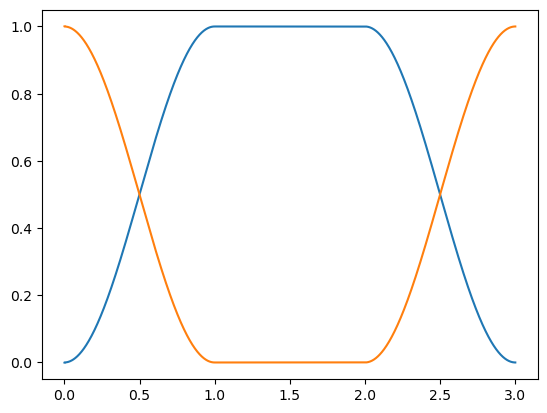

In [913]:
# Test code for unitary evolution with noisy time series
gamma = [[pi]+axis(pi/2,0)+[0, 1], [pi] + axis(0, 0)+[0,1], [-pi]+axis(pi/2,0)+[0, 1]]
h_list, times = create_H_list(np.array(gamma), 0.001, noise_type=-1, S=0)
us = unitary_evo_piecewise(h_list)

plt.plot(times, np.real(us[:, 1,0])**2 + np.imag(us[:, 1,0])**2)
plt.plot(times, np.imag(us[:, 0,0])**2 + np.real(us[:, 0,0])**2)

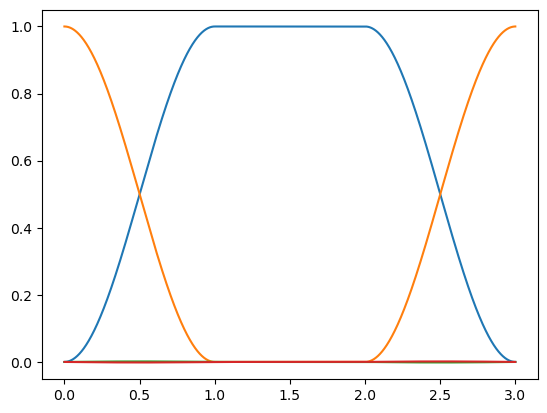

In [ ]:
#gamma = [[pi, 0, 0, 1], [0, pi/2, 0,1], [-pi, 0, 0, 1]]

temporal_polys, polys = create_polys_equiXYZ(gamma)
upoly = U_qsp_from_polys(times, temporal_polys)

plt.plot(times, np.real(upoly[:, 1,0])**2 + np.imag(upoly[:, 1,0])**2)
plt.plot(times, np.imag(upoly[:, 0,0])**2 + np.real(upoly[:, 0,0])**2)
plt.plot(times, np.real(us[:, 1,0])**2 + np.imag(us[:, 1,0])**2 - (np.real(upoly[:, 1,0])**2 + np.imag(upoly[:, 1,0])**2))
plt.plot(times, np.imag(us[:, 0,0])**2 + np.real(us[:, 0,0])**2 - (np.imag(upoly[:, 0,0])**2 + np.real(upoly[:, 0,0])**2))

0.001


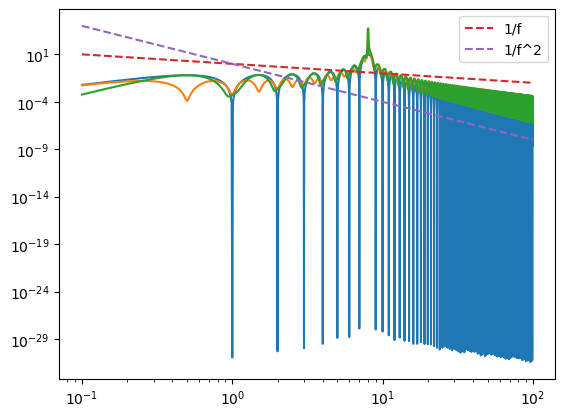

In [ ]:
gamma = [[pi, 0, 0, 1], [pi, pi/2, 0,1], [-pi, 0, 0, 1]]
gamma = [[8, 0, 0, 2*pi]]

temporal_polys, polys = create_polys_equiXY(gamma)
filterfunclist =  create_filter_funcs_list(polys)
print(times[2]-times[1])
freqs = np.arange(0.1, 100, 0.01)
u_filterfunc = U_qsp_filter_funcs(freqs, filterfunclist)

rx = np.real(u_filterfunc[:, 1,0])
ry = np.imag(u_filterfunc[:, 1,0])
rz = u_filterfunc[:, 0,0]

plt.loglog(freqs, np.abs(rx)**2 + np.abs(ry)**2)
plt.loglog(freqs, np.abs(rz)**2+ np.abs(ry)**2)
plt.loglog(freqs, np.abs(rz)**2+ np.abs(rx)**2)
#plt.loglog(freqs, np.abs(rz)**2)
 # plot 1/f for comparison
plt.loglog(freqs, 1/(freqs**2), '--', label='1/f^2')
plt.loglog(freqs, 1/(freqs**4), '--', label='1/f^4')
plt.legend()

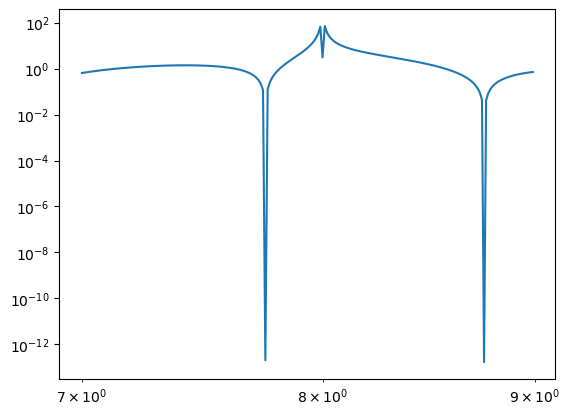

In [895]:
freqs = np.arange(7, 9, 0.01)
testcj = [cj(f, 1, 8, 2*pi, eps=1e-8) for f in freqs]
plt.loglog(freqs, np.abs(testcj), label='test cj')

#### Test instant equiangular vs numerical unitary_evo

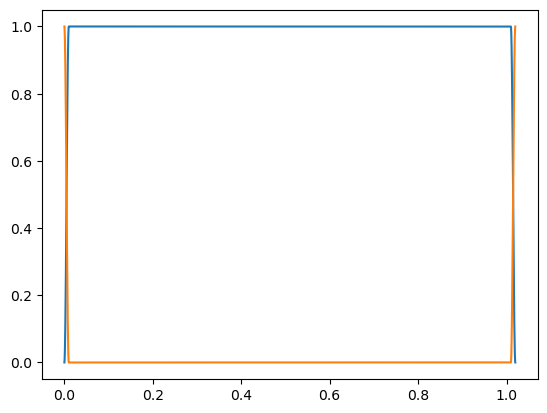

In [927]:
# Test code for unitary evolution with no noisy time series
small_t = 0.01
gamma = [[pi/small_t]+axis(pi/2,0)+[0, small_t], [pi/2] + axis(0,0)+[0,1], [-pi/small_t]+axis(pi/2,0)+[0, small_t]]
h_list, times = create_H_list(np.array(gamma), 0.0001, noise_type=-1, S=0)

us = unitary_evo_piecewise(h_list)
temporal_polys, polys = create_polys_equiXYZ(gamma)
upoly = U_qsp_from_polys(times, temporal_polys)

plt.plot(times, np.real(us[:, 1,0])**2 + np.imag(us[:, 1,0])**2)
plt.plot(times, np.imag(us[:, 0,0])**2 + np.real(us[:, 0,0])**2)

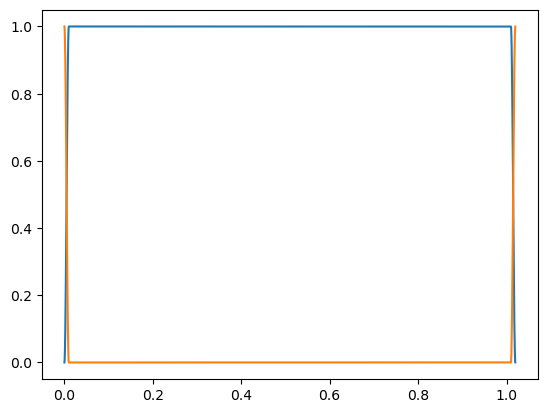

In [909]:
plt.plot(times, np.real(upoly[:, 1,0])**2 + np.imag(upoly[:, 1,0])**2)
plt.plot(times, np.imag(upoly[:, 0,0])**2 + np.real(upoly[:, 0,0])**2)


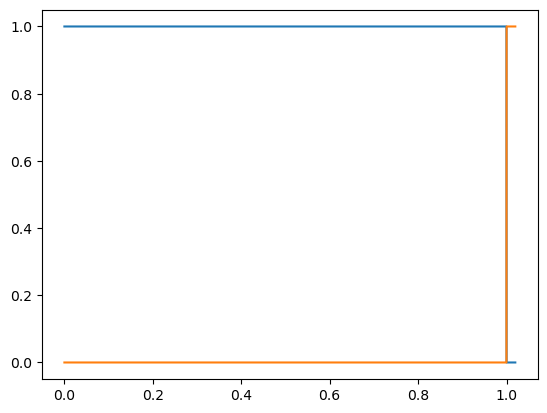

In [935]:
delta = pi/4
params = [[0, 0, 0], [delta, 1, pi], [0, 0, pi]]

instpolys, polys = create_polys_instantEq(params)
uInst = U_qsp_from_polys(times, instpolys)

plt.plot(times, np.real(uInst[:, 1,0])**2 + np.imag(uInst[:, 1,0])**2)
plt.plot(times, np.imag(uInst[:, 0,0])**2 + np.real(uInst[:, 0,0])**2)

0.0001


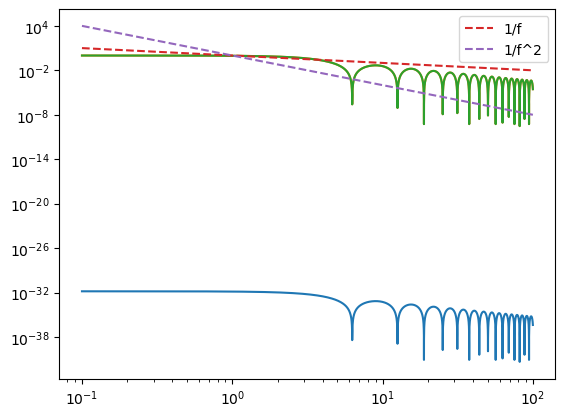

In [ ]:
filterfunclist =  create_instant_filter_funcs_list(polys)
print(times[2]-times[1])
freqs = np.arange(0.1, 100, 0.01)
u_filterfunc = U_qsp_filter_funcs(freqs, filterfunclist)

rx = np.real(u_filterfunc[:, 1,0])
ry = np.imag(u_filterfunc[:, 1,0])
rz = u_filterfunc[:, 0,0]

plt.loglog(freqs, np.abs(rx)**2 + np.abs(ry)**2)
plt.loglog(freqs, np.abs(rz)**2+ np.abs(ry)**2)
plt.loglog(freqs, np.abs(rz)**2+ np.abs(rx)**2)
#plt.loglog(freqs, np.abs(rz)**2)
 # plot 1/f for comparison
plt.loglog(freqs, 1/(freqs**2), '--', label='1/f^2')
plt.loglog(freqs, 1/(freqs**4), '--', label='1/f^4')
plt.legend()

### Expectation values and filter functions for temporal QSP

In [ ]:
def bloch_vector_from_U(U):
    """
    Calculate the Bloch vector from a 2x2 unitary operator U.

    Parameters:
    U: np.ndarray
        A 2x2 unitary operator.

    Returns:
    np.ndarray
        A 3D Bloch vector [x, y, z].
    """
    # Ensure U is a numpy array
    U = np.array(U)

    # Calculate the components of the Bloch vector
    x = np.real(U[0, 1])
    y = np.imag(U[0, 1])
    z = U[0, 0]

    return np.array([x, y, z])

def bloch_vector_t(U_list):
    """
    Calculate the Bloch vector trajectory from a list of 2x2 unitary operators U(t).

    Parameters:
    U_list: np.ndarray
        An array of shape (num_time_points, 2, 2) containing unitary operators at each time point.

    Returns:
    np.ndarray
        An array of shape (num_time_points, 3) containing the Bloch vector at each time point.
    """
    num_time_points = U_list.shape[0]
    bloch_vectors = np.zeros((num_time_points, 3), dtype=float)

    for t in range(num_time_points):
        bloch_vectors[t] = bloch_vector_from_U(U_list[t])

    return bloch_vectors

def var_delta_op(measurement_op, U_QSP_list, noise_time_series, times, initial_state=np.array([1,0])):
    """
    Calculate the standard deviation of the expectation value of a measurement operator B
    using Kubo formula.

    Parameters:
    measurement_op: np.ndarray
        The measurement operator.
    U_QSP_list: np.ndarray
        An array containing unitary operators at each time point.
    noise_time_series: np.ndarray
        An array of shape (num_time_points,) containing the noise values at each time point.
    times: np.ndarray
        An array of shape (num_time_points,) containing the time points corresponding to U_QSP_list and noise_time_series.
    initial_state: np.ndarray
        The initial state vector.

    Returns:
    float
        The variance of the expectation value of the measurement operator.
    """
    num_time_points = U_QSP_list.shape[0]
    # Transform measurement operator to interaction picture at time T
    measurement_op =  U_QSP_list[-1].conj().T @ measurement_op @ U_QSP_list[-1]

    comm_x = np.zeros(num_time_points, dtype=float)
    comm_y = np.zeros(num_time_points, dtype=float)
    comm_z = np.zeros(num_time_points, dtype=float)

    # Calculate the commutator [B_I(T), H_tilde(t)] at each time point
    comm = np.zeros(num_time_points, dtype=float)
    for t in range(num_time_points):
        H_tilde = noise_time_series[t] * U_QSP_list[t].conj().T @ (sz / 2) @ U_QSP_list[t]
        commutator = measurement_op @ H_tilde - H_tilde @ measurement_op
        bloch_vector_comm = bloch_vector_from_U(commutator)
        comm_x[t] = bloch_vector_comm[0]
        comm_y[t] = bloch_vector_comm[1]
        comm_z[t] = bloch_vector_comm[2]

    
    # Use simpsons rule to integrate comm[t] over time
    int_x = simpson(comm_x, times)
    int_y = simpson(comm_y, times)
    int_z = simpson(comm_z, times)
    integral = 2 * (int_x * sx + int_y * sy + int_z * sz)

    int2 = integral @ integral

    var = np.abs((initial_state.conj().T @ int2 @ initial_state))

    return var

def avg_var_trajectories(params, dt, measurement_op, N=10, noise_type = -1, S=0, initial_state=np.array([1,0])):
    """
    Calculate variance of expectation value of operator over multiple noisy QSP trajectories.
    params: list of pulse parameters [omega_k, axis_k, delta_k, tau_k] 
        where omega_k is rotation amplitude, axis_k is rotation axis angle, delta_k is detuning, tau_k is duration
    dt: time step to create U_QSP_list at and noise time series
    measurement_op: np.ndarray
        The measurement operator.
    N: number of noise trajectories to average over
    noise_type: type of noise to add (-1 = none, 0 = White, 1 = 1/f, 2 = 1/f^2, etc)
    S: spectral density scaling factor
    initial_state: np.ndarray
        The initial state vector.
    """

    #Calculate U_QSP_list
    h_list, times = create_H_list(params, dt, noise_type = noise_type, S=S)
    U_QSP_list = unitary_evo_piecewise(h_list)

    # Generate noise time series for N trajectories at times
    total_num_bins = len(times)
    variances = []
    for n in range(N):
        if noise_type >= 0:
            noise_time_series = generate_time_series(lambda f:S/(f ** noise_type + 1e-14), total_num_bins, dt)[0]
        else:
            noise_time_series = np.zeros(total_num_bins)
        var = var_delta_op(measurement_op, U_QSP_list, noise_time_series, times, initial_state=initial_state)
        variances.append(var)
    
    return np.mean(variances)